Datasets diambil dari https://www.kaggle.com/hgultekin/bbcnewsarchive

#### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from google.colab import files

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Upload datasets

In [2]:
uploaded = files.upload()

Saving bbc-news-data.csv to bbc-news-data.csv


#### Membaca datasets

In [3]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')

print(f'Jumlah datasets: {len(df)}')
df.head()

Jumlah datasets: 2225


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


Melihat salah satu content

In [4]:
df.content[100]

' Australia is raising its benchmark interest rate to its highest level in four years despite signs of a slowdown in the country\'s economy.  The Reserve Bank of Australia lifted interest rates 0.25% to 5.5%, their first upwards move in more than a year. However, shortly after the Bank made its decision, new figures showed a fall in economic growth in the last quarter. The Bank said it had acted to curb inflation but the move was criticised by some analysts.  The rate hike was the first since December 2003 and had been well-flagged in advance. However, opposition parties and some analysts said the move was ill-timed given data showing the Australian economy grew just 0.1% between October and December and 1.5% on an annual basis.  The figures, representing a decline from the 0.2% growth in GDP seen between July and September, were below market expectations. Consumer spending remains strong, however, and the Bank is concerned about growing inflationary pressures. "Over recent months it h

Jumlah content per category berita

In [5]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

#### Data cleaning

Melakukan cleaning data dengan text processing menggunakan stopwords, stemmer, lemmatization, etc.

In [6]:
stopword = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

List punctuations yang digunakan untuk cleaning data

In [7]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [8]:
def clean_puncts(sentence):
  text = str(sentence)
  text = text.lower()
  # replace bentuk URL
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", text)
  # replace bentuk petik
  for k, v in replace_puncts.items():
    text = text.replace(k, f' {v} ')
  # replace bentuk karakter
  for punct in strip_chars:
    text = text.replace(punct, ' ') 
  # replace bentuk sign
  for punct in puncts:
    text = text.replace(punct, f' {punct} ')
      
  text = text.replace(" '", " ")
  text = text.replace("' ", " ")
  text = text.strip()
  return text

def clean_stopwords(text):
  return ' '.join([word.lower() for word in text.split() if word.lower() not in stopword])

def clean_stemmer(text):
  return ' '.join([stemmer.stem(word) for word in text.split()])

def clean_lemma(text):    
  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def clean_length(text):
  return ' '.join([word for word in text.split() if len(word) > 2])

# bentuk data X harus dalam bentuk df
def text_processing(content):
  content = content.apply(clean_stopwords)
  content = content.apply(clean_puncts)
  content = content.apply(clean_stemmer)
  content = content.apply(clean_lemma)
  content = content.apply(clean_length)
  return content

In [9]:
df_clean = df.copy() # copy terlebih dahulu
df_clean['content_clean'] = df_clean.apply(lambda x: text_processing(x[['content']]), axis=1) # lakukan text_processing dan masukkan hasilnya ke kolom baru
df_clean.head()

,category,filename,title,content,content_clean
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,quarterli profit medium giant timewarn jump 13...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,dollar hit highest level euro almost three mon...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,owner embattl russian oil giant yuko ask buyer...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,british airway blame high fuel price drop prof...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,share drink food firm alli domecq risen specul...


#### Data spliting

Memisahkan X (feature) dan y (label)

In [10]:
X_clean = list(df_clean.content_clean)
y = list(df_clean.category)

Memisahkan datasets menjadi data latih dan data test dengan test set sebesar 20% dari total dataset.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42, shuffle = True)

#### Tokenizing, Sequencing, dan Padding

Kemudian kita ubah setiap kata pada dataset kita ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, kita perlu membuat mengonversi setiap sampel menjadi sequence.

In [12]:
vocab_size = 15000
embedding_dim = 32
max_length = 256
trunc_type='post'
padding_type='post'
oov_tok = '<OOV>'

In [13]:
content_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
content_tokenizer.fit_on_texts(X_train) 
content_tokenizer.fit_on_texts(X_test)

word_index = content_tokenizer.word_index
 
sekuens_X_train = content_tokenizer.texts_to_sequences(X_train)
sekuens_X_test = content_tokenizer.texts_to_sequences(X_test)
 
padded_X_train = pad_sequences(sequences=sekuens_X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type) 
padded_X_test = pad_sequences(sequences=sekuens_X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f'length of words: {len(word_index)}')

length of words: 20128


In [14]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df_clean.category)
label_index = label_tokenizer.word_index

sekuens_y_train = np.array(label_tokenizer.texts_to_sequences(y_train))
sekuens_y_test = np.array(label_tokenizer.texts_to_sequences(y_test))

print(f'labels: {label_index}')

labels: {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


#### Pemodelan

Untuk arsitektur model kita menggunakan layer Embedding dengan dimensi embedding sebesar 32, serta dimensi dari input sebesar nilai vocab_size dan juga input_lenght dari max_lenght pada objek tokenizer. Jangan lupa panggil fungsi compile dan tentukan optimizer serta loss function yang akan dipakai oleh model.

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(df.category.unique()) + 1, activation='softmax') # +1 karena encoding-nya dimulai dari 1-5
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           480000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 128)          49664     
_________________________________________________________________
dropout (Dropout)            (None, 256, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

Memasang fungsi callbacks, 5 kali tidak ada perubahan pada val_loss, STOP!

Pada awalnya, saya menggunakan val_accuracy, akan tetapi setelah melihat plot untuk val_loss, menjelang akhir dari epochs, nilainya semakin besar. Maka dari itu, lebih baik early stop warning pada val_loss.

In [16]:
# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    #monitor='val_accuracy',
    monitor='val_loss',
    verbose=1
)

Loss dan optimizer yang tidak diajarkan di kelas: 

1.   sparse_categorical_crossentropy
2.   RMSProp

Note: walaupun setelah beberapa kali percobaan, model Adam mendapatkan hasil yang lebih baik, stabil di atas 0.95.
:)

In [17]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=tf.keras.optimizers.RMSprop(), 
    metrics=['accuracy']
)

#### Training

Terakhir kita dapat mulai melatih model kita dengan memanggil fungsi fit().

In [18]:
num_epochs = 35
hist = model.fit(
    padded_X_train, 
    sekuens_y_train, 
    epochs=num_epochs, 
    validation_data=(padded_X_test, sekuens_y_test), 
    callbacks=[
       early_stopping_callback
    ],
    verbose=2
)

Epoch 1/35
56/56 - 7s - loss: 1.6361 - accuracy: 0.2506 - val_loss: 1.4648 - val_accuracy: 0.4067
Epoch 2/35
56/56 - 6s - loss: 0.9748 - accuracy: 0.6483 - val_loss: 1.0476 - val_accuracy: 0.7910
Epoch 3/35
56/56 - 6s - loss: 0.4997 - accuracy: 0.8303 - val_loss: 0.7027 - val_accuracy: 0.8225
Epoch 4/35
56/56 - 6s - loss: 0.2495 - accuracy: 0.9230 - val_loss: 0.4409 - val_accuracy: 0.9258
Epoch 5/35
56/56 - 6s - loss: 0.1248 - accuracy: 0.9697 - val_loss: 0.2798 - val_accuracy: 0.9438
Epoch 6/35
56/56 - 6s - loss: 0.0673 - accuracy: 0.9826 - val_loss: 0.2638 - val_accuracy: 0.9371
Epoch 7/35
56/56 - 6s - loss: 0.0183 - accuracy: 0.9966 - val_loss: 0.1797 - val_accuracy: 0.9528
Epoch 8/35
56/56 - 6s - loss: 0.0661 - accuracy: 0.9927 - val_loss: 0.2081 - val_accuracy: 0.9438
Epoch 9/35
56/56 - 6s - loss: 0.0371 - accuracy: 0.9927 - val_loss: 0.1753 - val_accuracy: 0.9551
Epoch 10/35
56/56 - 6s - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.1567 - val_accuracy: 0.9573
Epoch 11/35
56/56 -

#### Evaluasi Model

Evaluasi skor loss dan accuracy pada data test

In [19]:
model.evaluate(padded_X_test, sekuens_y_test)

14/14 [==============================] - 0s 33ms/step - loss: 0.1869 - accuracy: 0.9663


[0.18693868815898895, 0.966292142868042]

Plotting loss dan accuracy pada data training dan data test

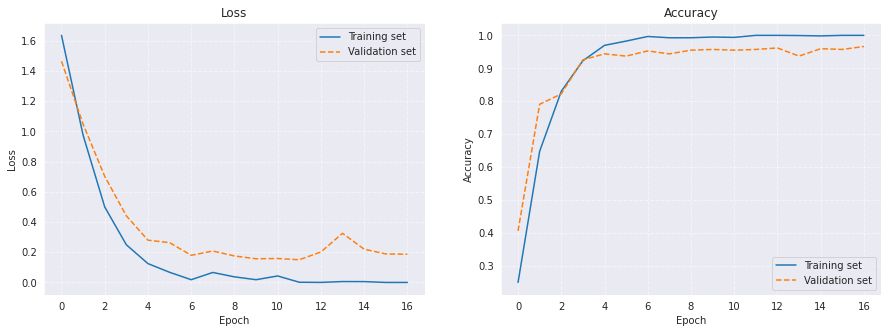

In [20]:
# Mengambil history dari loss dan accuracy
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Menampilkan graph loss dan accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

Plot y_actual dan y_predict dengan confusion matrix

In [21]:
y_pred = model.predict_classes(padded_X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Text(0.5, 69.0, 'Predicted')

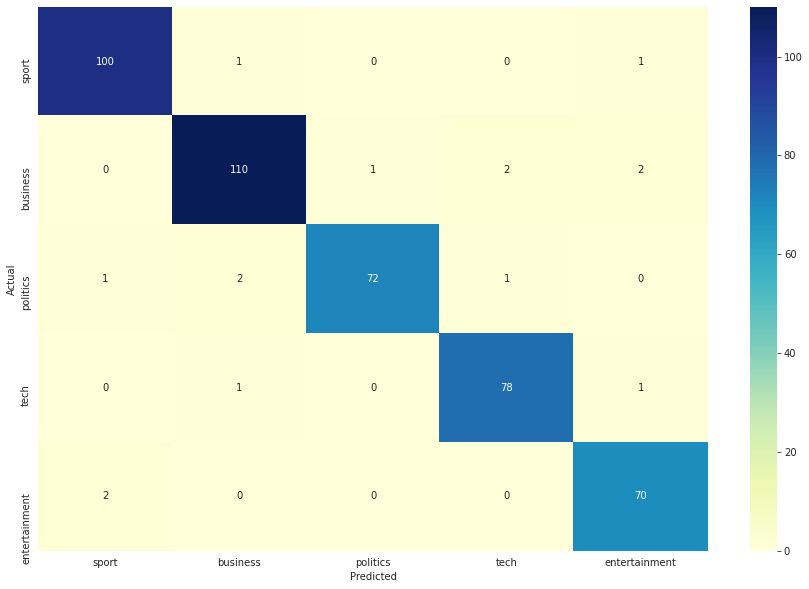

In [22]:
plt.figure(figsize=(15,10))
conf_mat = confusion_matrix(sekuens_y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=list(label_index.keys()), yticklabels=list(label_index.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')